# Modeling Churn: Random Forest Model

**Import Packages**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio
from functions import dummies, prepare_data, train_random_forest, train_random_forest_tuned, evaluate_model
from functions import plot_importance, save_to_pickle, load_from_pickle

In [2]:
# Load clean dataframe with engineered features
df = pd.read_csv('../data/raw/describe_price.csv')
df.to_pickle('../pickle/describe_price.pkl')
df.head()

,id,channel_sales,tenure_years,months_to_end,months_since_modified,months_since_renewed,yearly_consumption,monthly_consumption,yearly_gas_consumption,yearly_forecast_consumption,...,avg_price_peak_var,avg_price_mid_peak_var,price_peak_off_peak_ratio_var,std_price_off_peak_var,std_price_peak_var,std_price_mid_peak_var,range_price_peak_var,range_price_off_peak_var,range_price_mid_peak_var,churn
0,987e2767a9812e900db0041930d126cb,0,3,5,2,6,7502,0,0,276,...,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.004,0.000,0
1,5d5431b8305bb08ab589db356d2b54ef,0,3,9,24,2,27382,340,0,4061,...,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.004,0.000,0
2,17e84c1bc19211777dfbb1cca8af94fc,0,3,9,26,2,463646,40551,0,2859,...,0.102,0.072,0.836,0.004,0.002,0.001,0.004,0.008,0.003,0
3,dd490452dadf88529466072605d7ee82,0,3,5,2,6,3315,0,0,496,...,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.004,0.000,0
4,a33668b7d0d8d86f38ad983c0cad6095,0,3,12,11,0,63969,63969,7488,9683,...,0.114,0.069,0.655,0.014,0.056,0.049,0.152,0.044,0.104,0


In [3]:
# Create dummies for channel sales
df = dummies(df, ['channel_sales'])
df.head()

,id,tenure_years,months_to_end,months_since_modified,months_since_renewed,yearly_consumption,monthly_consumption,yearly_gas_consumption,yearly_forecast_consumption,yearly_forecast_meter_rent,...,std_price_mid_peak_var,range_price_peak_var,range_price_off_peak_var,range_price_mid_peak_var,churn,channel_sales_0,channel_sales_1,channel_sales_2,channel_sales_3,channel_sales_4
0,987e2767a9812e900db0041930d126cb,3,5,2,6,7502,0,0,276,16.05,...,0.000,0.000,0.004,0.000,0,1,0,0,0,0
1,5d5431b8305bb08ab589db356d2b54ef,3,9,24,2,27382,340,0,4061,13.92,...,0.000,0.000,0.004,0.000,0,1,0,0,0,0
2,17e84c1bc19211777dfbb1cca8af94fc,3,9,26,2,463646,40551,0,2859,117.54,...,0.001,0.004,0.008,0.003,0,1,0,0,0,0
3,dd490452dadf88529466072605d7ee82,3,5,2,6,3315,0,0,496,19.84,...,0.000,0.000,0.004,0.000,0,1,0,0,0,0
4,a33668b7d0d8d86f38ad983c0cad6095,3,12,11,0,63969,63969,7488,9683,148.38,...,0.049,0.152,0.044,0.104,0,1,0,0,0,0


## Random Forest Model

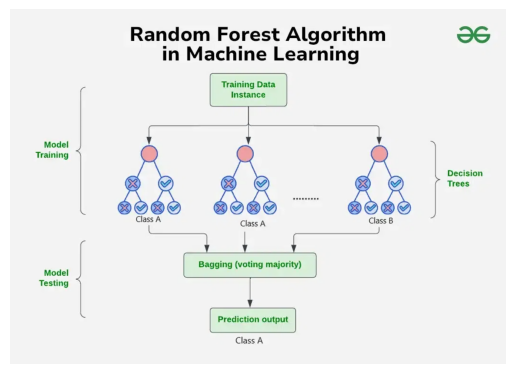

In [4]:
image = iio.imread('../plots/Random-Forest-Algorithm.png')
plt.imshow(image)
plt.axis('off');

**What is a Random Forest model?**

The Random Forest is an ensemble machine learning algorithm used for classification and regression tasks. It builds multiple decision trees during training and combines their outputs to make more accurate and robust predictions.

- Bagging: Trains each tree on a random subset of the data to reduce overfitting.
- Feature Randomness: Considers random subsets of features at each split, thereby lowering the correlation between trees.
- Ensemble Learning: Aggregates predictions (majority vote) from multiple trees to improve accuracy and stability.

**Why do I use a Random Forest model?**

Challenges with KNN:

- Requires to scale all features equally, which may not capture feature importance effectively.
- Computationally extensive for large datasets, as it requires to store the entire dataset and perform calculations for each prediction.
- KNN struggles with highly nonlinear relationships and imbalanced datasets.

Challenges with Logistic Regression:

- Assumes a linear relationship between features and the log-odds of the target, which may oversimplify the churn behavior. 
- Needs transformation or interaction terms to capture nonlinear patterns (Feature Engineering).
- Struggles with imbalanced datasets unless oversampling/undersampling techniques are applied.

Motivation to use a Decision-Tree Model:
- Decision trees model complex, nonlinear relationships between features and target without requiring extensive tuning or scaling.
- Provide information on which features are most influential in predicting churn, which may be important for business insights.
- Decision-tree-based models can handle missing data and outliers better than regression or KNN.
- The class_weight parameter ensures that the minority class is given appropriate importance.

Motivation to use a Random Forest Model:
- Random Forest scales efficiently with large datasets and high-dimensional data due to its efficient training process.
- Random Forest reduces overfitting compared to a single decision tree by averaging predictions across multiple trees.

**Why do I use the StandardScaler?**
- The StandardScaler is less sensitive to outliers and scales each column to a mean of 0 and a standard deviation of 1. 
- All features are treated on the same scale in terms of the standard deviation from the mean, which can be advantageous for consistent model training and feature importance interpretation. 
- The MinMaxScaler is useful for distance-based algorithms like KNN, but can distort scaling in the presence of outliers. 
- Without checking the metrics of all columns (minimum, maximum, normality) the StandardScaler is the safer options.


In [5]:
# Prepare the data
X_train, X_test, y_train, y_test, scaler = prepare_data(df, drop_columns = ['id'], target_column= "churn")

# Train the model with the train data
model = train_random_forest(X_train, y_train, n_estimators = 100, max_depth = 20)
# 100 estimators
# 20 tree depth

In [6]:
# Evaluate the model with the test data
evaluate_model(model, X_test, y_test)

## Hyperparameter Tuning

**Parameters**

*n_estimators*
- Number of trees in the forest.
- Default: 100.
- The number of trees in the forest directly impacts the model's performance and training time. Too few trees might underfit the data, while too many trees can lead to unnecessary computation.
- Controls the overall stability and accuracy of the model.

*max_depth*
- Maximum depth of each decision tree.
- Default: None (nodes are expanded until all leaves are pure or contain less than min_samples_split samples).
- The depth of the trees determines how much the model learns from the data. Deeper trees can capture more complex patterns but are prone to overfitting.
- Critical for balancing model complexity and generalization.

*min_samples_split*
- Minimum number of samples required to split an internal node.
- Default: 2.
- min_samples_split: This parameter controls when a node can be split. Larger values prevent overly deep trees and reduce overfitting.
- Helps create more generalizable models, particularly for datasets prone to overfitting.

*min_samples_leaf*
- Minimum number of samples required to be at a leaf node. 
- Default: 1.
- Ensures that leaf nodes have a minimum number of samples. This prevents the model from being overly sensitive to individual data points.
- Helps smooth decision boundaries and avoids creating overly complex trees (reduce overfitting).

*max_features*
- Number of features to consider when looking for the best split.
- Options: None (all features) sqrt (of the total number of features), log2 (of the total number of features), integer
- Controls randomness in splits. Smaller values increase randomness, thereby improving generalization.
- For classification, sqrt works well (default). For regression, use None or log2.

*class_weight*
- Weights associated with classes to address imbalanced datasets.
- Options: None (no weights), balanced (adjusts weights inversely proportional to class frequencies), or manually define weights for each class.
- Helps the model focus on minority classes, thereby improving recall for underrepresented categories.
- Default: None.

These four parameters are among the most influential for controlling the **bias-variance tradeoff** in Random Forests.

**Why do I use Bayesian search?**

- Grid search is simple since it covers the whole parameter space but it is computationally exhaustive. Since this parameter space is continuous, a very fine grid is needed.
- Random search is not systematic since it could miss optimal regions if random sampling does not hit them, and also inefficient because it randomly evaluates combinations without learning from past evaluations.
- Bayesian search uses past evaluations to estimate which hyperparameter regions are promising and explores them more. Meanwhile it balances exploration (trying new regions) and exploitation (focusing on areas with good results). It works well with continuous, large, or high-dimensional spaces as in this case.

**What is cross validation?**
1. The entire dataset is divided into a training set and a test set (e.g., 80% train, 20% test).
2. The test set is set aside for final evaluation and is not involved in the cross-validation or training.
3. The training set is further split into multiple folds (e.g., 5 folds).
4. For each fold: one subset is used for validation, and the remaining subsets are used for training. This process is repeated until every fold has been used once as the validation set.

**Why do I optimize for recall and not for accuracy?**

In [7]:
# Train the tuned model (inherent parameter optimization)
tuned_model = train_random_forest_tuned(X_train, y_train, n_trials = 50)

# Save to pkl file to store output
save_to_pickle(tuned_model, '../pickle/tuned_model.pkl')

[I 2024-12-20 09:50:25,133] A new study created in memory with name: no-name-3dea1cbd-8275-44ac-87c7-2a65746d0aab
[I 2024-12-20 09:50:56,731] Trial 0 finished with value: 0.20088105726872246 and parameters: {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.20088105726872246.
[I 2024-12-20 09:51:11,496] Trial 1 finished with value: 0.1920704845814978 and parameters: {'n_estimators': 109, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.20088105726872246.
[I 2024-12-20 09:51:23,084] Trial 2 finished with value: 0.23524229074889869 and parameters: {'n_estimators': 110, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.23524229074889869.
[I 2024-12-20 09:51:35,634] Trial 3 finished with value: 0.20881057268722464 and parameters: {'n_estimators': 94, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 2 with 

The best parameters are: {'n_estimators': 97, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 3}


In [8]:
# Load model from file
tuned_model = load_from_pickle('../pickle/tuned_model.pkl')

# Evaluate the tuned model
tuned_scores = evaluate_model(tuned_model, X_test, y_test)
tuned_scores.write_image('../plots/tuned_scores.png', scale = 6)

In [9]:
#tuned_model = pd.read_pickle('../pickle/tuned_model.pkl')
#tuned_model

In [9]:
best_params = {
    "Number of Trees": tuned_model.n_estimators,
    "Maximum Tree Depth": tuned_model.max_depth,
    "Minimum Samples of a Split": tuned_model.min_samples_split,
    "Minimum Samples of a Leaf": tuned_model.min_samples_leaf}

# Convert to DataFrame
best_params_df = pd.DataFrame([best_params], index = [""])
best_params_df

,Number of Trees,Maximum Tree Depth,Minimum Samples of a Split,Minimum Samples of a Leaf
,97,10,2,3


# Feature Importances

In [11]:
plot_importance(model, X_train)

In [ ]:
plot_importance(tuned_model, X_train)